# The trend, what is it good for?

Trend approaches to investing get a lot of press, and, tbh, it has always sounded like investment numerology to me. But wouldn't it be nice if I had some, you know, _actual data_ to back up my beliefs? Yes it would.

So I came up a simple experiment to measure how useful trend estimators really are. Here's my approach: using whatever trend estimator is under test, identify candidate "inflection points." Then, test these candidate by looking at what happened to the market afterwards for different time periods, and see if there are significant performance differences as compared to the baseline performance data generally.

## The first experiment: 50-day rolling means worst performers
    
To start, I'm going to use the 50-day rolling mean of the S&P 500 index's adjusted close as the trend estimator. I'll find my candidate inflection points by looking for the biggest negative (percentwise) changes in the 50DRM, then look at what happened to the index's performance in the subsequent time periods, and compare those results against the performance for all the samples using the same time periods. Will these inflection points be predictive?

#### The preliminaries

We'll start by importing some needed modules and setting some display and formatting options. The Python data analysis tools module pandas will do the heavy lifting. We'll use matplotlib for plotting. If you're running this as a live IPython notebook -- highly recommended! -- you'll see some plotting interactivity with IPython's widgets.

In [27]:
%matplotlib inline
from datetime import date 
import IPython.html.widgets as widgets
import IPython.display as display
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
import pandas.io.data as web

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pylab.rcParams['figure.figsize'] = 14, 8
pd.set_option('display.width', 400)

Get the S&P 500 index historical performance data, aka SPY, and serialize it to disk.

In [28]:
try:
    perf_df = pd.read_pickle('sp500histdata')
except:
    perf_df = web.DataReader("SPY", 'yahoo', date(1900,1,1), date(2015,7,1)) # Yahoo dataset actually starts at 1/29/1993
    perf_df.to_pickle('sp500histdata')

#### Get the baseline SPY data ready

The first task is to assemble the baseline SPY perfomance data. We'll build a DataFrame where each row is labelled by the length of time that's being looked at, and each column is a bin that holds the percentage of samples periods in that row that fall into that column's performance range. So row 20 will be all the twenty-day sample periods in the SPY performance dataset, and row 20, column +0.02%, is the percentage of twenty-day sample periods where the percentage increase was in the +1%-to-+2% bucket. We'll also capture basic description statistics for each time period.

In [29]:
def _bin( s, bins ):
    '''Using an input Series of floats and a list of bin values, return
    a Series with the bin labels as indexes and a count of the input series values
    in that bin as the values.
    
    The bin labels are the exclusive upper bound, that is, ( COL i-1, COL i ].
    The code will create a final bin label, OVER, for counting values at or above
    the last user-supplied bin value'''
    binned_s = pd.Series( index = bins )

    for idx, b in enumerate(bins):
        if idx == 0:
            binned_s.loc[b] = s[ s < b ].count()
        else:
            binned_s.loc[b] = s[ s >= last_b][ s < b ].count()
        last_b = b
    binned_s.loc["OVER"] = s[ s >= bins[-1] ].count()
    
    return binned_s

def build_performance_pc_series( s, n ):
    return s.pct_change( n )

def build_baseline_performance_tables( s, bins = [ x * .01 for x in range(-30,31) ], days_range = range(1,91)) :
    '''Take a series s and produce two DataFrames that analyze the performance of that series over a
    range of period lengths, given in days. 
    
    The first DataFrame is computed by taking the series percentage change over a range
    of period lengths, and then bins those data. The result is a DataFrame with the various period
    ranges as columns, and the performance bin labels as the index. The value in the
    DataFrame's cell is the ratio of the count of percentage changes for that bin and period
    length to the total number of samples for that period length.
    
    The second DataFrame holds summary statistics for the percentage change data, broken
    down by period length. Each column is the period length, and each index is a summary statistic.
    
    Bins are a list of bin defnitions to use. Days_range is a list of period ranges to use.'''
    
    baseline_binned_pc_df = pd.DataFrame( columns = days_range, index = bins )
    # add an "OVER" row to capture out-of-range results
    tmp_over_row_df = pd.DataFrame( columns = days_range, index = ["OVER"] )
    baseline_binned_pc_df = baseline_binned_pc_df.append(tmp_over_row_df)
    baseline_summary_df = pd.DataFrame( columns = days_range )

    for d in days_range:
        # get the historical performance percentage change for series s and window length d 
        pc_change = build_performance_pc_series( s, d )
        total_samples = float(pc_change.count())
        # save summary statistics about the percentage change data
        baseline_summary_df[d] = pc_change.describe()
        # bin the percentage change data
        binned_pc_change = _bin( pc_change, bins )
        # save the binned performance counts as a percentage of all the samples for this window length
        baseline_binned_pc_df[d] = binned_pc_change / total_samples
        
    return (baseline_binned_pc_df, baseline_summary_df)

Let's do a quick sanity check of the code I wrote above, using fake input data.

In [30]:
# build some fake data that always increases between 0 and 1% from one day to the next,
# between 1 and 2% over any given two day period, and so on.
INPUT_LENGTH = 20 # how many samples to generate
df = pd.DataFrame( index = [0], columns = range(0,INPUT_LENGTH) )
df[0][0] = 100.0
for i in range(1,INPUT_LENGTH):
    df[i] = df[i-1] * 1.009
test_data = df.iloc[0]

# build the performance tables with this test data
(test_data_binned_pc_df, test_data_summary_df) = build_baseline_performance_tables(test_data,bins = [ x * .01 for x in range(1,11) ],days_range=range(1,11))
# this result should show all the one day samples returning 0-1%, all the two day samples returning 1-2% ...
print test_data_binned_pc_df
# check that the mean is within the intended ranges for each day, and that the standard deviation is 0.
print test_data_summary_df

         1      2      3      4      5      6      7      8      9      10
0.01 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.02 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.03 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.04 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.05 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.06 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
0.07 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
0.08 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.09 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
0.1  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000
OVER 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
           1       2       3       4       5       6       7       8       9       10
count 19.0000 

Looks good. Now let's build our baseline performance tables using the real SPY dataset and plot the results. We'll use IPython widgets to make the GUI interactive. The slider bar controls the length of the sample period in days.

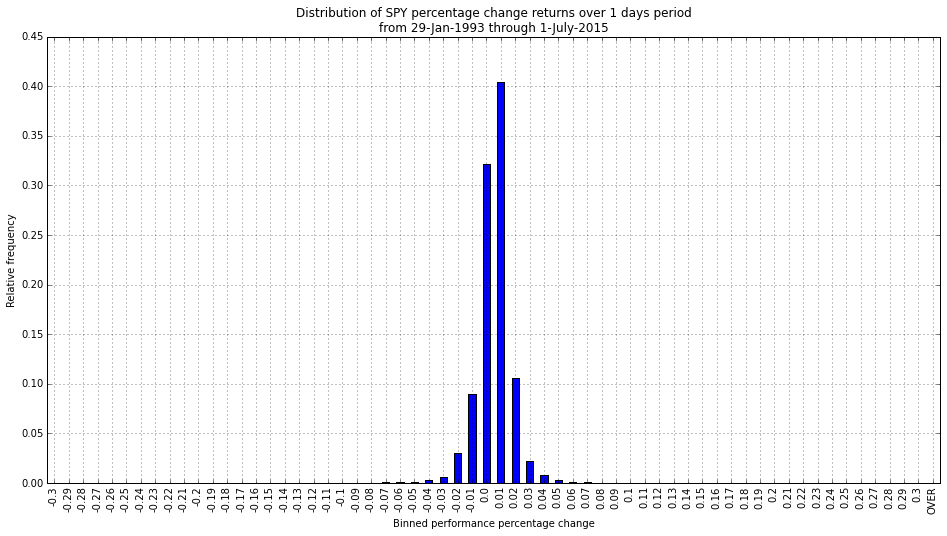

In [31]:
# build the baseline SPY performance tables and display it
def buildmybaselineplotf( baseline_adj_close_s ):
    # build the baseline data DataFrames
    (baseline_binned_pc_df, baseline_summary_df) = build_baseline_performance_tables(baseline_adj_close_s)
    def baselineplotf( days ):
        title = 'Distribution of SPY percentage change returns over ' + str(days) + ' days period\n' + \
        'from 29-Jan-1993 through 1-July-2015'
        ax = baseline_binned_pc_df[ days ].plot('bar', title = title, figsize=(16,8))
        ax.set_xlabel('Binned performance percentage change')
        ax.set_ylabel('Relative frequency')
    return baselineplotf

baselineplotf = buildmybaselineplotf(perf_df['Adj Close'])
days_slider = widgets.IntSlider(min=1,max=90,step=1,value=1,description="Period length (1 to 90 days)")
container = widgets.interaction.interactive( baselineplotf, days = days_slider )
display.display(container)

So that's what the distribution of the binned performance change data for the entire SPY dataset looks like.

Now let's look at summary statistics for these data and see how they vary with the length of the sample period. Use the dropdown to pick a statistic. By default, we'll set it to the median.

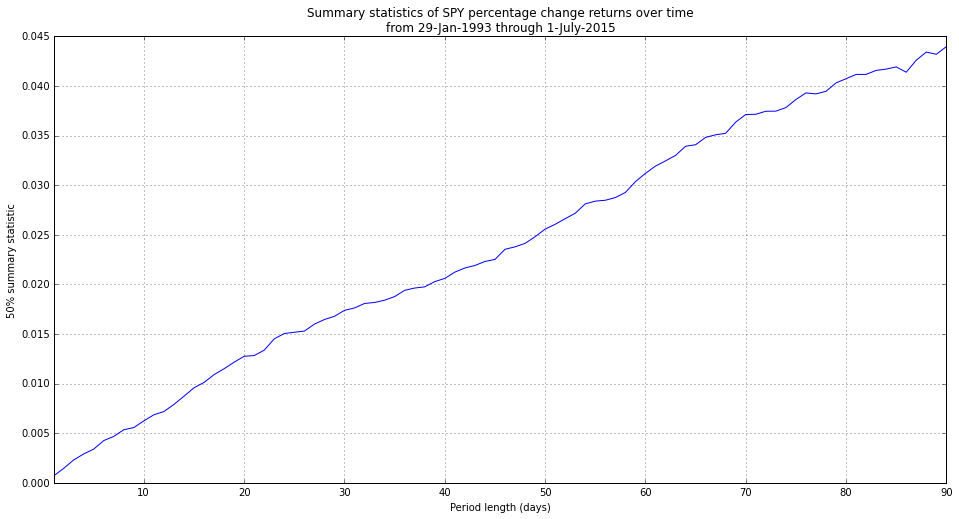

In [32]:
# build the baseline SPY performance tables and display the summary statistics
def buildmybaselinesummaryplotf( baseline_adj_close_s ):
    # build the baseline data DataFrames
    (baseline_binned_pc_df, baseline_summary_df) = build_baseline_performance_tables(baseline_adj_close_s)
    def baselinesummaryplotf( statistic = '50%' ):
        title = 'Summary statistics of SPY percentage change returns over time\n' + \
        'from 29-Jan-1993 through 1-July-2015'
        ax = baseline_summary_df.transpose()[statistic].plot(title=title,figsize=(16,8))
        ax.set_xlabel('Period length (days)')
        ax.set_ylabel(statistic + ' summary statistic')
    return baselinesummaryplotf

baselinesummaryplotf = buildmybaselinesummaryplotf(perf_df['Adj Close'])
container = widgets.interaction.interactive( baselinesummaryplotf, statistic=tuple(baseline_summary_df.index.tolist()) )
display.display(container)

#### Select our candidiate inflection points from SPY's rolling means

We've got our baseline SPY performance data, broken down by period lengths. Now we need to get candidate inflection points from our trend estimator.

We're using 50-day rolling means trend estimators, so we'll build a series with that data. Our candidate inflection points will be the bottom _n_ percent of values. Because there might be other trend estimators in our hypothesis-testing future, we'll build an abstract base class for the general case, and the Rolling Mean trend estimator will be our concrete implementation.

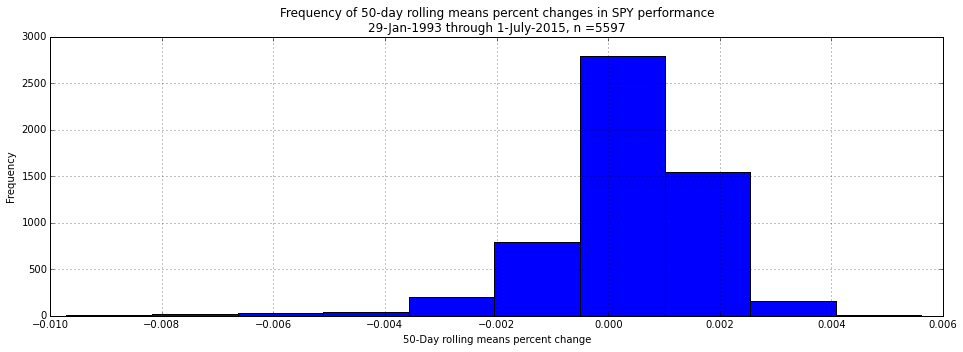

In [33]:
from abc import ABCMeta, abstractmethod

class TrendEstimator:
    '''abstract base class for trend estimators'''
    __metaclass__ = ABCMeta
    @abstractmethod
    def getBottomValues( self, threshold ):
        '''implementations should return a timestamp-indexed series of the lowest performance changes
        below a given threshold'''
        pass
    @abstractmethod
    def getTopValues( self, threshold ):
        '''implementations should return a timestamp-indexed series of the highest performance changes
        above a given threshold'''
        pass

class RollingMeanTrendEstimator(TrendEstimator):
    '''a rolling mean trend estimator class'''
    def __init__(self,s,n):
        '''build a series based on the rolling means of given series and a window of length n'''
        self.data = pd.rolling_mean( s, n ).pct_change().order()
        self.num_samples = self.data.count()
    def getBottomValues( self, threshold ):
        performers = int( self.num_samples * threshold )
        return self.data.head(performers)
    def getTopValues( self, threshold ):
        performers = int( self.num_samples * threshold )
        return self.data.tail(performers)

# build the 50-day trend estimator using the SPY adjusted close data
_50DRM = RollingMeanTrendEstimator(perf_df['Adj Close'], 50)

# plot the rolling mean data as a frequency
title='Frequency of 50-day rolling means percent changes in SPY performance\n29-Jan-1993 through 1-July-2015, n =' + \
        str(_50DRM.data.count())
ax = _50DRM.data.plot('hist', title=title, figsize=(16,5))
ax.set_xlabel('50-Day rolling means percent change')
ax.set_ylabel('Frequency')

Now let's see what the worst performers for the 50 day rolling means percentage change dataset look like. Use the slider bar to set the threshold value.

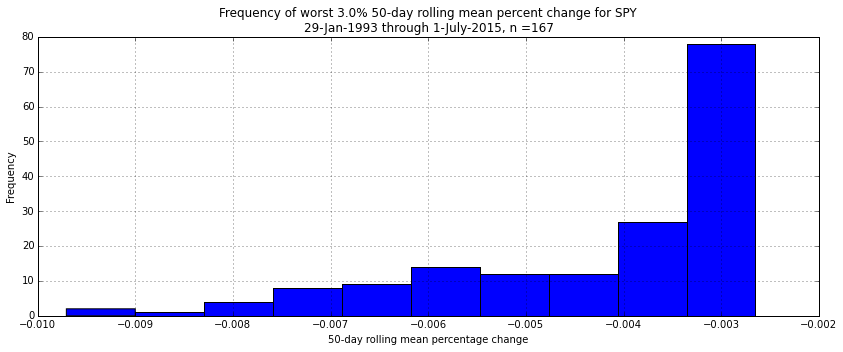

In [34]:
# get candidate inflection points from the 50-day rolling means instance and display them
def buildmybottompcf( estimator ):
    def bottompcf( threshold ):
        candidates = estimator.getBottomValues( threshold )
        percent = threshold * 100
        title='Frequency of worst ' + str(percent) + '% 50-day rolling mean percent change for SPY\n' + \
        '29-Jan-1993 through 1-July-2015, n =' + str(candidates.count())
        ax = candidates.plot('hist', title = title, figsize=(14,5))
        ax.set_xlabel('50-day rolling mean percentage change')
        ax.set_ylabel('Frequency')
    return bottompcf

bottomplotf = buildmybottompcf(_50DRM)
threshold_slider = widgets.FloatSlider(min=.01,max=.25,step=.01,value=.03,description="threshold")
container = widgets.interaction.interactive( bottomplotf, threshold = threshold_slider )
display.display(container)

Now we have our candidate inflection points. Our next task is to build a table of post-inflection point performance percent changes for a range of period lengths. Then we take that table and the baseline performance table we built earlier and construct a third table that compares the them, period length by period length.

The function build_ip_performance_tables() returns a DataFrame that looks like what we got from build_baseline_performance_tables() before. It's indexed by binned performances, each column is a period range. Each entry is the percent of performance percentage changes for the period length of that row that fall into its columnar performance bin.

The difference is that build_baseline_performance_tables() built this table using the entire SPY dataset. For build_ip_performance_tables(), we just want to make these calculations for a subset: our candidate inflection points that our trend estimator identified. Since we know the timestamps for the candidate inflection points, we can build a series using just these timestamps -- and that's what build_performance_pc_series_using_timestamps() does.

And as we did before, we'll also grab the summary statistics for each period length.

In [35]:
def build_performance_pc_series_using_timestamps( df, timestamps, n ):
    '''Given a DataFrame indexed by Timestamps, returns the performance 
    percentage change values for a given timestamp and window n. The window
    units are in days'''
    windowed_df = df.pct_change( n )
    results = []
    for t in timestamps:
        try:
            # get an index into windowed_df for this timestamp
            start_idx = windowed_df.index.get_loc(t)
        except:
            raise "could not find row location for index " + str(t)
        # figure out where the position of the end of the window is
        end_idx = start_idx + n
        # save the percentage_change at the end_idx, if it exists
        try:
            results.append( windowed_df[end_idx] )
        except IndexError:
            # this row does not exist
            pass
    return pd.Series( results )

def build_ip_performance_tables( df, timestamps, bins = [ x * .01 for x in range(-30,31) ], days_range = range(1,60)) :
    '''Take a timestamp-indexed series s and a list of timestamps to select out of the series 
    and produce two DataFrames that analyze the performance of that series subset over a range
    of period lengths, given in days. 
    
    The first DataFrame is computed by taking the series subset percentage change over a range
    of period lengths, and then bins those data. The result is a DataFrame with the various period
    ranges as columns, and the performance bin labels as the index. The value in the
    DataFrame's cell is the ratio of the count of percentage changes for that bin and period
    length to the total number of samples for that period length.
    
    The second DataFrame holds summary statistics for the percentage change data, broken
    down by period length. Each column is the period length, and each index is a summary statistic.
    
    Bins are a list of bin defnitions to use. Days_range is a list of period ranges to use.'''
        
    ip_binned_pc_df = pd.DataFrame( columns = days_range, index = bins )
    # add an "OVER" row to capture out-of-range results
    tmp_over_row_df = pd.DataFrame( columns = days_range, index = ["OVER"] )
    ip_binned_pc_df = ip_binned_pc_df.append(tmp_over_row_df)
    ip_summary_df = pd.DataFrame( columns = days_range )

    for d in days_range:
        # get the windowed performance percent change data for the selected timestamps
        pc_change = build_performance_pc_series_using_timestamps( df, timestamps, d )
        total_samples = float( pc_change.count() )
        # save summary statistics about the percentage change data
        ip_summary_df[d] = pc_change.describe()
        # bucketize the performance percent change data
        binned_pc_change = _bin( pc_change, bins )
        ip_binned_pc_df[d] = binned_pc_change / total_samples
        
    return ( ip_binned_pc_df, ip_summary_df )

Let's do a quick sanity check on this code with some test data.

In [36]:
# start by building some fake data that always increases between 0 and 1% from one day to the next,
# between 1 and 2% over any given two day period, and so on. This data is indexed with timestamps.
INPUT_LENGTH = 20 # how many samples to generate
timestamps = pd.date_range("1/1/2000", periods=INPUT_LENGTH)
df = pd.DataFrame( index = [0], columns = timestamps )
df[ timestamps[0] ] = 100.0
for i in timestamps[1:]:
    df[i] = df[i-1] * 1.009
test_data = df.transpose()[0]

# this should show a series with all the values being just under the window value
print build_performance_pc_series_using_timestamps( test_data, timestamps, 3 )
(test_data_binned_pc_df, test_data_summary_df) = build_ip_performance_tables(test_data,timestamps,bins = [ x * .01 for x in range(1,11) ],days_range=range(1,11))
# this result should show all the one day samples returning 0-1%, all the two day samples returning 1-2% ...
print test_data_binned_pc_df
# check that the mean is within the intended ranges for each day, and that the standard deviation is 0.
print test_data_summary_df

0    0.0272
1    0.0272
2    0.0272
3    0.0272
4    0.0272
5    0.0272
6    0.0272
7    0.0272
8    0.0272
9    0.0272
10   0.0272
11   0.0272
12   0.0272
13   0.0272
14   0.0272
15   0.0272
16   0.0272
dtype: float64
         1      2      3      4      5      6      7      8      9      10
0.01 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.02 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.03 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.04 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.05 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.06 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
0.07 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
0.08 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.09 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
0.1  0.0000 0.0000 0.0000 0.000

Now let's create the candidate inflection point performance tables and display them.

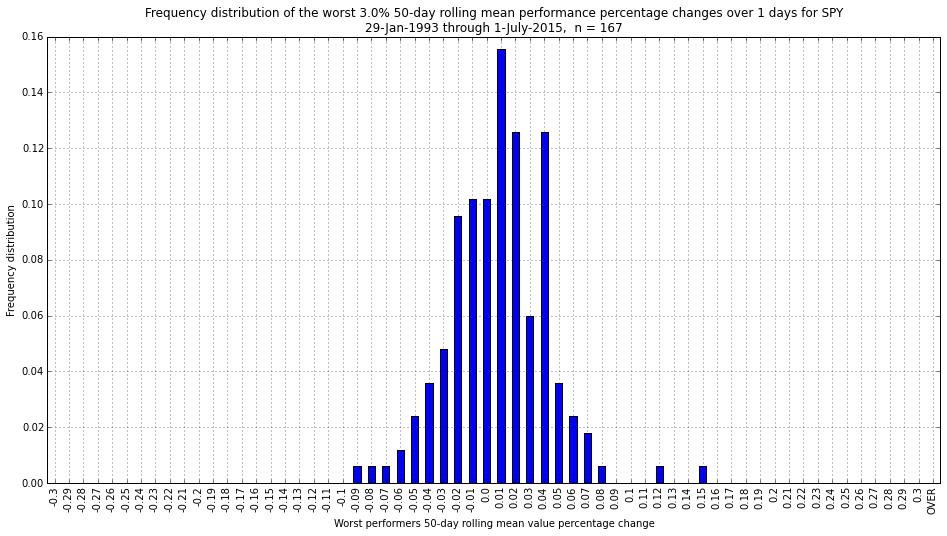

In [37]:
# for a given threshold, grab the worst performers from our 50 day rolling mean percentage change
# trned estimator and build performance tables for these data and display
def buildmybinnedbottompcplotf( baseline_df, estimator ):
    def binnedbottompcplotf( threshold, days ):
        candidates = estimator.getBottomValues( threshold )
        percent = threshold * 100
        (ip_binned_pc_df, ip_summary_df) = build_ip_performance_tables( baseline_df, candidates.index )
        title='Frequency distribution of the worst ' + str(percent) + \
        '% 50-day rolling mean performance percentage changes over ' + str(days) + ' days for SPY\n' + \
        '29-Jan-1993 through 1-July-2015, ' + ' n = ' + str(candidates.count())
        ax = ip_binned_pc_df[ days ].plot('bar', title = title, figsize = (16,8))
        ax.set_xlabel('Worst performers 50-day rolling mean value percentage change')
        ax.set_ylabel('Frequency distribution')
    return binnedbottompcplotf

binnedbottompcplotf = buildmybinnedbottompcplotf( perf_df['Adj Close'], _50DRM )
threshold_slider = widgets.FloatSlider(min=.01,max=.25,step=.01,value=.03,description="Threshold")
days_slider = widgets.IntSlider(min=1,max=90,step=1,value=1,description="Period length (1 to 90 days)")
container = widgets.interaction.interactive( binnedbottompcplotf, threshold = threshold_slider, days = days_slider )
display.display(container)

#### Compare the baseline SPY performance with the candidiate inflection points

We've got the performance tables for the baseline case, and the performance tables for our candidiate inflection points from our 50-day rolling means estimator. Now it's time to write the code that compares these two datasets. Which brings up the question: how are we going to quantify the difference in the two distributions?

We'll keep it simple, and use the median. That is, we compare the median of the post-inflection point performance change with the median performance change for the baseline samples over one day, then two days, and so on. We'll plot the result.

In [38]:
def build_comparison_table( baseline_summary_df, ip_summary_df, stat ):
    comparison_df = pd.DataFrame( columns = [ "rolling_mean", "baseline", "diff"] )
    comparison_df['rolling_mean'] = ip_summary_df.transpose()[stat]
    comparison_df['baseline'] = baseline_summary_df.transpose()[stat]
    comparison_df['diff'] = comparison_df['rolling_mean'] - comparison_df['baseline']
    return comparison_df

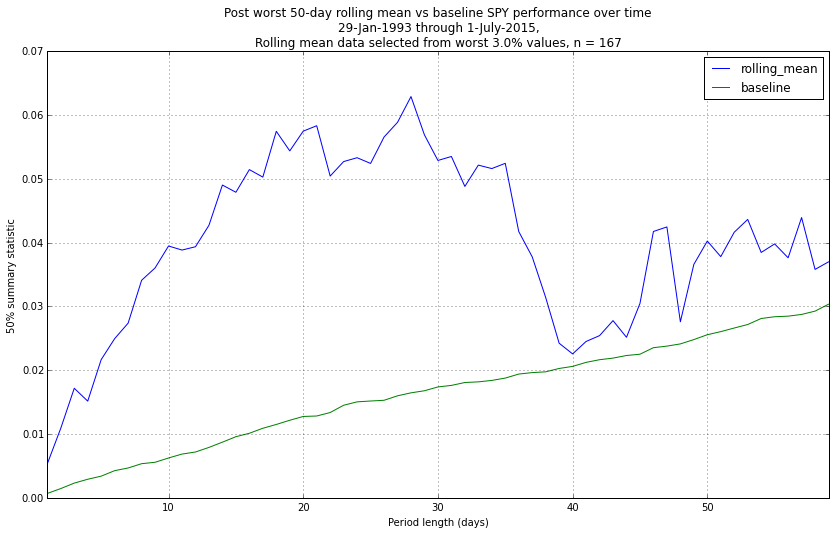

In [39]:
# compare the 50DRM worst performers against the baseline SPY performance and display
def buildmybottomcomparisonf( baseline_df, baseline_summary_df, estimator, statistic ):
    def bottomcomparisonf( threshold ):
        candidate_inflection_points = estimator.getBottomValues( threshold )
        (ip_bucketized_pc_df, ip_summary_df) = build_ip_performance_tables( baseline_df, candidate_inflection_points.index)
        comparison_df = build_comparison_table( baseline_summary_df, ip_summary_df, statistic )
        percent = threshold * 100
        title='Post worst 50-day rolling mean vs baseline SPY performance over time\n' + \
            '29-Jan-1993 through 1-July-2015,\n' + \
            'Rolling mean data selected from worst ' + str(percent) + '% values, n = ' + str(candidate_inflection_points.count())
        ax = comparison_df.drop('diff',1).plot(title = title)
        ax.set_xlabel("Period length (days)")
        ax.set_ylabel( statistic + ' summary statistic' )
    return bottomcomparisonf

bottomcomparisonf = buildmybottomcomparisonf(perf_df['Adj Close'], baseline_summary_df, _50DRM, '50%' )
threshold_slider = widgets.FloatSlider(min=.01,max=1.0,step=.01,value=.03,description="Threshold")
container = widgets.interaction.interactive( bottomcomparisonf, threshold = threshold_slider )
display.display(container)

When you look at small thresholds -- say, 3% -- there's quite a performance spread. But do you see a problem here?

I do: for small thresholds, we have a really tiny candidate inflection point population size. If you're all YOLO, I'm happy for you, but I need more data before I'm convinced that we have something truly predictive. So let's move that slider bar up to .10 and see the 50DRM is trying to tell us.

Oh. Not nearly as exciting.

And that's the problem with torturing the SPY data series until some correlations fall out of it and then thinking you found a magic key: there usually isn't enough data to prove that what you found really is a magic key, and not some highly entertaining noise.